# Classifier Comparison Visualization

This notebook visualizes the comparison of 11 oversampling methods across 29 datasets,
4 classifiers (RandomForest, DecisionTree, kNN, MLP), and 4 metrics (AUROC, G-mean, MCC, F1-score).

**Methods compared:**
- Original (no oversampling)
- ROS (Random OverSampling)
- SMOTE
- bSMOTE (Borderline-SMOTE)
- ADASYN
- MWMOTE
- CTGAN
- GAMO
- MGVAE
- MMD (beta=0.0)
- MMD+T (beta=0.01)


In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pathlib import Path

# ============================================================================
# Publication-Quality Style Settings (NeurIPS/ICML/ICLR compatible)
# ============================================================================

# Use LaTeX-like fonts for publication quality
plt.rcParams.update({
    # Font settings - use serif fonts similar to LaTeX
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif', 'Computer Modern Roman'],
    'mathtext.fontset': 'cm',  # Computer Modern for math
    
    # Font sizes (adjusted for ~3.25in column width figures)
    'font.size': 9,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.title_fontsize': 9,
    
    # Figure settings
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.02,
    
    # Axes settings
    'axes.linewidth': 0.8,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'axes.axisbelow': True,
    'grid.alpha': 0.3,
    'grid.linewidth': 0.5,
    'grid.linestyle': '--',
    
    # Tick settings
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    
    # Legend settings
    'legend.frameon': True,
    'legend.framealpha': 0.9,
    'legend.edgecolor': '0.8',
    'legend.fancybox': False,
    
    # Line settings
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
})

# Column width for NeurIPS/ICML papers (in inches)
COLUMN_WIDTH = 3.25
TEXT_WIDTH = 6.75
GOLDEN_RATIO = 1.618

print("Publication-quality style settings loaded.")


Publication-quality style settings loaded.


In [2]:
# Define paths
BASE_PATH = Path('../../results/ablations')
CLASSIFIERS_PATH = BASE_PATH / 'classifiers'
BETAS_PATH = BASE_PATH / 'betas'
REAL_EXAMPLES_PATH = BASE_PATH / 'real_examples'

# 29 datasets from the paper
DATASETS_29 = [
    'abalone19', 'abalone9-18', 'arrhythmia', 'cleveland-0_vs_4', 'coil_2000',
    'ecoli3', 'ecoli4', 'glass-0-1-2-3_vs_4-5-6', 'glass-0-1-6_vs_5', 'glass4',
    'oil', 'ozone_level', 'pima', 'scene', 'segment0',
    'sick_euthyroid', 'solar_flare_m0', 'thyroid_sick', 'us_crime', 'wine_quality',
    'winequality-red-3_vs_5', 'winequality-red-4', 'winequality-white-3_vs_7',
    'winequality-white-3-9_vs_5', 'yeast-0-5-6-7-9_vs_4', 'yeast-1-2-8-9_vs_7',
    'yeast-1-4-5-8_vs_7', 'yeast4', 'yeast6'
]

# 4 classifiers
CLASSIFIERS = ['DecisionTree', 'RandomForest', 'kNN', 'MLP']

# 4 metrics
METRICS = ['AUROC', 'G-mean', 'MCC', 'F1-score']

# 11 methods to compare (in display order)
METHODS = ['Original', 'ROS', 'SMOTE', 'bSMOTE', 'ADASYN', 'MWMOTE', 'CTGAN', 
           'GAMO', 'MGVAE', 'MMD', 'MMD+T']

print(f"Number of datasets: {len(DATASETS_29)}")
print(f"Classifiers: {CLASSIFIERS}")
print(f"Metrics: {METRICS}")
print(f"Methods: {METHODS}")


Number of datasets: 29
Classifiers: ['DecisionTree', 'RandomForest', 'kNN', 'MLP']
Metrics: ['AUROC', 'G-mean', 'MCC', 'F1-score']
Methods: ['Original', 'ROS', 'SMOTE', 'bSMOTE', 'ADASYN', 'MWMOTE', 'CTGAN', 'GAMO', 'MGVAE', 'MMD', 'MMD+T']


In [3]:
def load_classifiers_data(dataset_name):
    """
    Load data from classifiers folder.
    Returns data for: Original, ROS, SMOTE, bSMOTE, ADASYN, MWMOTE, CTGAN
    """
    file_path = CLASSIFIERS_PATH / f"{dataset_name}_results.csv"
    if not file_path.exists():
        return None
    
    df = pd.read_csv(file_path)
    # Filter only relevant methods and classifiers
    methods_map = {
        'Original': 'Original',
        'ROS': 'ROS', 
        'SMOTE': 'SMOTE',
        'bSMOTE': 'bSMOTE',
        'ADASYN': 'ADASYN',
        'MWMOTE': 'MWMOTE',
        'CTGAN': 'CTGAN'
    }
    
    df = df[df['Method'].isin(methods_map.keys())]
    df = df[df['Classifier'].isin(CLASSIFIERS)]
    df = df[df['Metric'].isin(METRICS)]
    
    return df[['Method', 'Classifier', 'Metric', 'Value']]


def load_mmd_only_data(dataset_name):
    """
    Load MMD data from betas folder (beta_0.0.csv).
    """
    file_path = BETAS_PATH / f"{dataset_name}_results_gaussian_beta_0.0.csv"
    if not file_path.exists():
        return None
    
    df = pd.read_csv(file_path)
    df = df[df['Classifier'].isin(CLASSIFIERS)]
    df = df[df['Metric'].isin(METRICS)]
    df['Method'] = 'MMD'
    
    return df[['Method', 'Classifier', 'Metric', 'Value']]


def load_mmd_triplet_data(dataset_name):
    """
    Load MMD+T data from betas folder (beta_0.01.csv).
    """
    file_path = BETAS_PATH / f"{dataset_name}_results_gaussian_beta_0.01.csv"
    if not file_path.exists():
        return None
    
    df = pd.read_csv(file_path)
    df = df[df['Classifier'].isin(CLASSIFIERS)]
    df = df[df['Metric'].isin(METRICS)]
    df['Method'] = 'MMD+T'
    
    return df[['Method', 'Classifier', 'Metric', 'Value']]


def load_gamo_mgvae_data(dataset_name):
    """
    Load GAMO and MGVAE data from real_examples folder (GAMO_MGVAE files).
    """
    # Search for GAMO_MGVAE files with any beta value
    pattern = str(REAL_EXAMPLES_PATH / f"{dataset_name}_results_GAMO_MGVAE_beta_*.csv")
    files = glob.glob(pattern)
    
    if not files:
        return None
    
    # Use the first matching file (they should have the same structure)
    df = pd.read_csv(files[0])
    df = df[df['Classifier'].isin(CLASSIFIERS)]
    df = df[df['Metric'].isin(METRICS)]
    df = df[df['Method'].isin(['GAMO', 'MGVAE'])]
    
    return df[['Method', 'Classifier', 'Metric', 'Value']]


# Test loading
test_df = load_classifiers_data('abalone9-18')
print(f"Classifiers data shape: {test_df.shape if test_df is not None else None}")
print(test_df.head() if test_df is not None else None)


Classifiers data shape: (112, 4)
      Method    Classifier Metric    Value
1   Original  DecisionTree  AUROC  0.66013
2   Original           kNN  AUROC  0.68049
3   Original           MLP  AUROC  0.58917
4   Original  RandomForest  AUROC  0.83723
10     SMOTE  DecisionTree  AUROC  0.67474


In [4]:
# Load all data
all_data = []
datasets_loaded = []

for dataset in DATASETS_29:
    # Load from classifiers folder
    clf_df = load_classifiers_data(dataset)
    if clf_df is not None:
        clf_df['Dataset'] = dataset
        all_data.append(clf_df)
    
    # Load MMD from betas
    mmd_only_df = load_mmd_only_data(dataset)
    if mmd_only_df is not None:
        mmd_only_df['Dataset'] = dataset
        all_data.append(mmd_only_df)
    
    # Load MMD+T from betas
    mmd_triplet_df = load_mmd_triplet_data(dataset)
    if mmd_triplet_df is not None:
        mmd_triplet_df['Dataset'] = dataset
        all_data.append(mmd_triplet_df)
    
    # Load GAMO and MGVAE from real_examples
    gamo_mgvae_df = load_gamo_mgvae_data(dataset)
    if gamo_mgvae_df is not None:
        gamo_mgvae_df['Dataset'] = dataset
        all_data.append(gamo_mgvae_df)
    
    if clf_df is not None:
        datasets_loaded.append(dataset)

# Combine all data
df_all = pd.concat(all_data, ignore_index=True)
print(f"Total rows: {len(df_all)}")
print(f"Datasets loaded: {len(datasets_loaded)}")
print(f"\nDatasets: {datasets_loaded}")


Total rows: 5104
Datasets loaded: 29

Datasets: ['abalone19', 'abalone9-18', 'arrhythmia', 'cleveland-0_vs_4', 'coil_2000', 'ecoli3', 'ecoli4', 'glass-0-1-2-3_vs_4-5-6', 'glass-0-1-6_vs_5', 'glass4', 'oil', 'ozone_level', 'pima', 'scene', 'segment0', 'sick_euthyroid', 'solar_flare_m0', 'thyroid_sick', 'us_crime', 'wine_quality', 'winequality-red-3_vs_5', 'winequality-red-4', 'winequality-white-3_vs_7', 'winequality-white-3-9_vs_5', 'yeast-0-5-6-7-9_vs_4', 'yeast-1-2-8-9_vs_7', 'yeast-1-4-5-8_vs_7', 'yeast4', 'yeast6']


In [5]:
# Check data availability
print("Data availability per method:")
method_counts = df_all.groupby('Method')['Dataset'].nunique()
for method in METHODS:
    count = method_counts.get(method, 0)
    print(f"  {method}: {count} datasets")

print(f"\nUnique methods in data: {df_all['Method'].unique()}")


Data availability per method:
  Original: 29 datasets
  ROS: 29 datasets
  SMOTE: 29 datasets
  bSMOTE: 29 datasets
  ADASYN: 29 datasets
  MWMOTE: 29 datasets
  CTGAN: 29 datasets
  GAMO: 29 datasets
  MGVAE: 29 datasets
  MMD: 29 datasets
  MMD+T: 29 datasets

Unique methods in data: ['Original' 'SMOTE' 'ADASYN' 'bSMOTE' 'ROS' 'MWMOTE' 'CTGAN' 'MMD' 'MMD+T'
 'GAMO' 'MGVAE']


In [6]:
# Calculate average metrics per method and classifier
def compute_avg_metrics(df, methods_to_include):
    """
    Compute average metrics for each method and classifier combination.
    """
    df_filtered = df[df['Method'].isin(methods_to_include)].copy()
    
    # Calculate mean across datasets
    avg_df = df_filtered.groupby(['Method', 'Classifier', 'Metric'])['Value'].mean().reset_index()
    avg_df = avg_df.rename(columns={'Value': 'Mean'})
    
    # Also calculate std
    std_df = df_filtered.groupby(['Method', 'Classifier', 'Metric'])['Value'].std().reset_index()
    std_df = std_df.rename(columns={'Value': 'Std'})
    
    # Merge
    result = avg_df.merge(std_df, on=['Method', 'Classifier', 'Metric'])
    
    return result

avg_metrics = compute_avg_metrics(df_all, METHODS)
print(f"Average metrics shape: {avg_metrics.shape}")
avg_metrics.head(20)


Average metrics shape: (176, 5)


,Method,Classifier,Metric,Mean,Std
0,ADASYN,DecisionTree,AUROC,0.759916,0.122117
1,ADASYN,DecisionTree,F1-score,0.390527,0.274520
2,ADASYN,DecisionTree,G-mean,0.667241,0.191511
3,ADASYN,DecisionTree,MCC,0.370602,0.271418
4,ADASYN,MLP,AUROC,0.849354,0.101411
5,ADASYN,MLP,F1-score,0.378168,0.224055
6,ADASYN,MLP,G-mean,0.709513,0.157398
7,ADASYN,MLP,MCC,0.367771,0.213128
8,ADASYN,RandomForest,AUROC,0.883615,0.097802
9,ADASYN,RandomForest,F1-score,0.428174,0.296110


In [17]:
# ============================================================================
# Color Palette and Method Configuration
# ============================================================================
# Design principle: MMD+T (Ours) should stand out visually with RED
# - Baselines: muted/neutral colors (gray/blue tones)
# - Deep learning baselines (CTGAN, GAMO, MGVAE): muted tones
# - Ours (MMD, MMD+T): BOLD RED tones for maximum emphasis ★

# Color scheme optimized for publication
METHOD_COLORS = {
    # Baselines - neutral/cool tones (muted, de-emphasized)
    'Original': '#bdbdbd',       # Light gray
    'ROS': '#969696',            # Medium gray
    'SMOTE': '#74a9cf',          # Light blue
    'bSMOTE': '#3690c0',         # Medium blue  
    'ADASYN': '#0570b0',         # Dark blue
    'MWMOTE': '#045a8d',         # Darker blue
    
    # Deep learning baselines - muted tones (not competing with Ours)
    'CTGAN': '#fdae6b',          # Light orange (muted)
    'GAMO': '#a1d99b',           # Light green (muted)
    'MGVAE': '#bcbddc',          # Light purple (muted)
    
    # ★★★ Ours - BOLD RED tones for maximum emphasis ★★★
    'MMD': '#fc9272',            # Light red/salmon (ablation)
    'MMD+T': '#cb181d',          # Bold crimson red (primary - Ours)
}

# Method display order (logical grouping)
METHOD_ORDER = [
    'Original', 'ROS', 'SMOTE', 'bSMOTE', 'ADASYN', 'MWMOTE',  # Traditional
    'CTGAN', 'GAMO', 'MGVAE',                                   # Deep learning
    'MMD', 'MMD+T'                                   # MMD+T
]

# Display names for publication (with "MMD+T" label)
METHOD_LABELS = {
    'Original': 'Original',
    'ROS': 'ROS',
    'SMOTE': 'SMOTE', 
    'bSMOTE': 'bSMOTE',
    'ADASYN': 'ADASYN',
    'MWMOTE': 'MWMOTE',
    'CTGAN': 'CTGAN',
    'GAMO': 'GAMO',
    'MGVAE': 'MGVAE',
    'MMD': 'MMD',
    'MMD+T': 'MMD+T',  # Highlight as our method
}

# Classifier display names
CLASSIFIER_LABELS = {
    'RandomForest': 'RF',
    'DecisionTree': 'DT',
    'kNN': 'kNN',
    'MLP': 'MLP'
}

print("Color palette and labels configured.")


Color palette and labels configured.


Saved: ../../results/figures/classifier_comparison_main.pdf


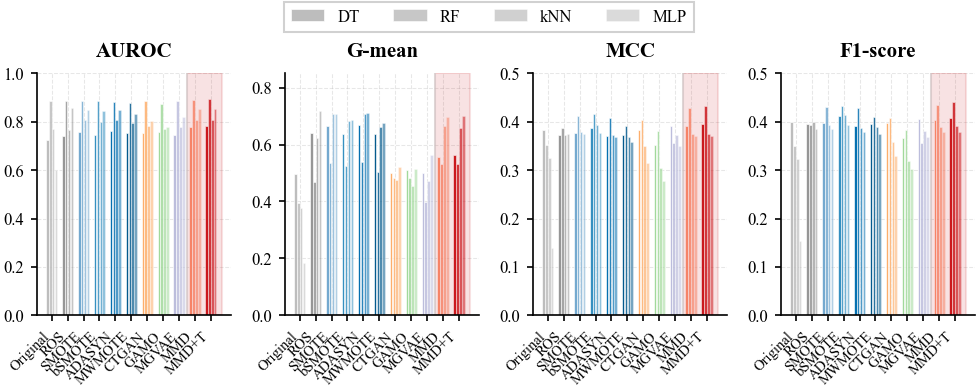

In [18]:
# ============================================================================
# Main Visualization: Classifier-Agnostic Performance
# ============================================================================
# Key message: MMD+T (MMD+T) consistently produces high-quality samples
# across ALL classifiers, demonstrating classifier-agnostic sample quality.

def create_classifier_agnostic_bar_chart(avg_df, classifiers, metrics, method_order, 
                                          method_colors, method_labels, classifier_labels,
                                          figsize=None, save_path=None):
    """
    Create a publication-quality grouped bar chart.
    
    Layout: 1 row x 4 columns (one per metric)
    Each subplot shows methods on x-axis, with bars for each classifier grouped together.
    This emphasizes: "For each metric, our method works well across all classifiers"
    """
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH / 2.5)
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
    
    # Filter only methods that exist in data
    available_methods = [m for m in method_order if m in avg_df['Method'].unique()]
    n_methods = len(available_methods)
    n_classifiers = len(classifiers)
    
    # Bar width and positions
    bar_width = 0.18
    x = np.arange(n_methods)
    
    # Classifier colors (shades of each method's color or distinct)
    classifier_hatches = ['', '///', '...', 'xxx']  # Different patterns
    classifier_alphas = [1.0, 0.85, 0.7, 0.55]
    
    for j, metric in enumerate(metrics):
        ax = axes[j]
        
        for k, classifier in enumerate(classifiers):
            mask = (avg_df['Classifier'] == classifier) & (avg_df['Metric'] == metric)
            plot_data = avg_df[mask].copy()
            
            # Ensure method order
            plot_data['Method'] = pd.Categorical(plot_data['Method'], 
                                                  categories=available_methods, 
                                                  ordered=True)
            plot_data = plot_data.sort_values('Method')
            
            # Get values in correct order
            values = plot_data['Mean'].values
            stds = plot_data['Std'].values
            
            # Position for this classifier's bars
            pos = x + (k - n_classifiers/2 + 0.5) * bar_width
            
            # Get colors
            colors = [method_colors.get(m, '#333333') for m in available_methods]
            
            # Create bars
            bars = ax.bar(pos, values, bar_width * 0.9, 
                         color=colors, 
                         alpha=classifier_alphas[k],
                         edgecolor='white',
                         linewidth=0.3,
                         label=classifier_labels.get(classifier, classifier) if j == 0 else '')
            
            # Error bars (only show for cleaner look, or comment out)
            # ax.errorbar(pos, values, yerr=stds, fmt='none', color='#333333', 
            #            capsize=1.5, capthick=0.4, linewidth=0.4, alpha=0.7)
        
        # Formatting
        ax.set_xticks(x)
        ax.set_xticklabels([method_labels.get(m, m) for m in available_methods], 
                          rotation=45, ha='right', fontsize=7)
        
        # Set y-axis limits (start from 0 to show all values including low MLP Original)
        if metric == 'AUROC':
            ax.set_ylim(0, 1.0)
        elif metric == 'G-mean':
            ax.set_ylim(0, 0.85)
        elif metric == 'MCC':
            ax.set_ylim(0, 0.50)
        else:  # F1-score
            ax.set_ylim(0, 0.50)
        
        ax.set_title(metric, fontsize=10, fontweight='bold', pad=8)
        
        # Add vertical line to separate "Ours"
        ax.axvline(x=n_methods - 2.5, color='#cccccc', linestyle='-', linewidth=0.8, alpha=0.7)
        
        # Highlight "Ours" region with subtle RED background
        ax.axvspan(n_methods - 2.5, n_methods - 0.3, alpha=0.12, color='#cb181d')
    
    # Add single legend for classifiers
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, 
               bbox_to_anchor=(0.5, 1.02), frameon=True, fontsize=8)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create the main visualization
fig = create_classifier_agnostic_bar_chart(
    avg_metrics, 
    CLASSIFIERS, 
    METRICS, 
    METHOD_ORDER, 
    METHOD_COLORS,
    METHOD_LABELS,
    CLASSIFIER_LABELS,
    save_path='../../results/figures/classifier_comparison_main.pdf'
)


Saved: ../../results/figures/classifier_comparison_per_classifier.pdf


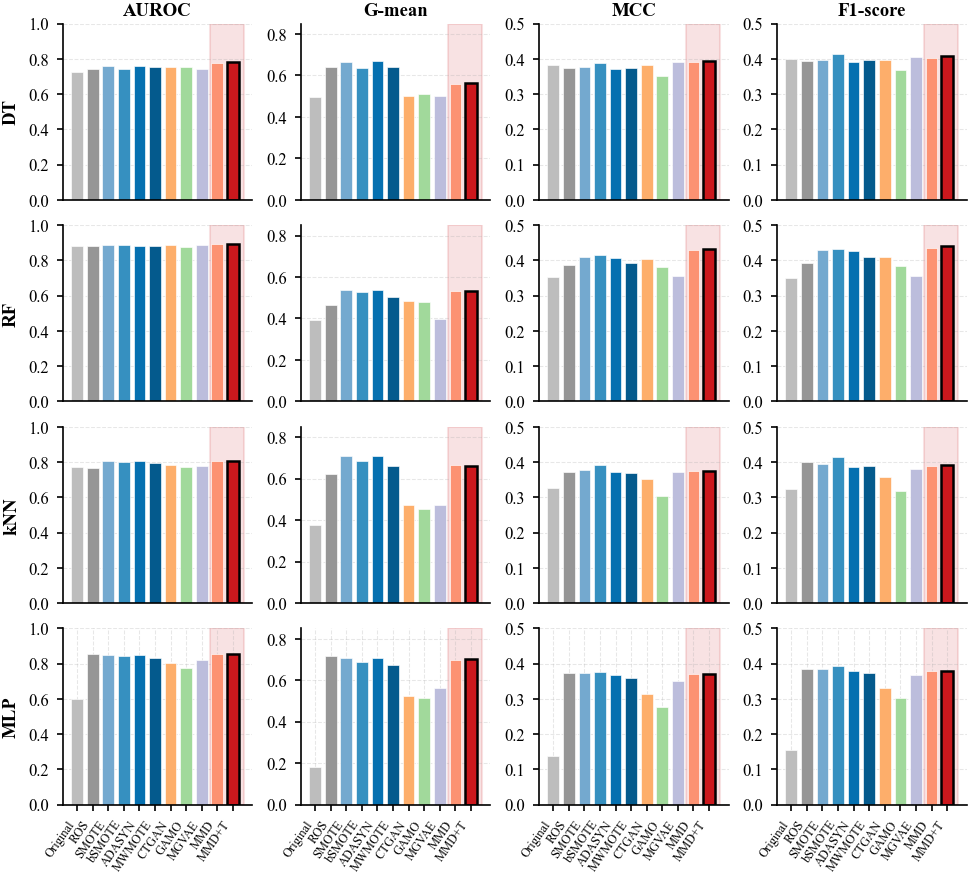

In [19]:
# ============================================================================
# Key Visualization: Per-Classifier Performance (Main Figure for Paper)
# ============================================================================
# This figure clearly shows that MMD+T (MMD+T) achieves consistent 
# performance across different classifiers.

def create_per_classifier_comparison(avg_df, classifiers, metrics, method_order, 
                                      method_colors, method_labels, classifier_labels,
                                      figsize=None, save_path=None):
    """
    Create a 4x4 grid (classifiers x metrics) showing method performance.
    Each cell shows bars for all methods, emphasizing consistency of "MMD+T".
    """
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH * 0.9)
    
    fig, axes = plt.subplots(len(classifiers), len(metrics), figsize=figsize)
    
    available_methods = [m for m in method_order if m in avg_df['Method'].unique()]
    n_methods = len(available_methods)
    
    for i, classifier in enumerate(classifiers):
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            mask = (avg_df['Classifier'] == classifier) & (avg_df['Metric'] == metric)
            plot_data = avg_df[mask].copy()
            
            plot_data['Method'] = pd.Categorical(plot_data['Method'], 
                                                  categories=available_methods, 
                                                  ordered=True)
            plot_data = plot_data.sort_values('Method')
            
            x = np.arange(len(plot_data))
            values = plot_data['Mean'].values
            colors = [method_colors.get(m, '#333333') for m in plot_data['Method']]
            
            # Create bars with emphasis on "MMD+T"
            bars = ax.bar(x, values, color=colors, edgecolor='white', linewidth=0.3, width=0.75)
            
            # Highlight "MMD+T" with edge
            for idx, m in enumerate(plot_data['Method']):
                if m == 'MMD+T':
                    bars[idx].set_edgecolor('#000000')
                    bars[idx].set_linewidth(1.2)
            
            # Y-axis limits (start from 0 to show all values including low MLP Original)
            if metric == 'AUROC':
                ax.set_ylim(0, 1.0)
            elif metric == 'G-mean':
                ax.set_ylim(0, 0.85)
            elif metric == 'MCC':
                ax.set_ylim(0, 0.50)
            else:  # F1-score
                ax.set_ylim(0, 0.50)
            
            # Labels
            if i == 0:
                ax.set_title(metric, fontsize=9, fontweight='bold', pad=4)
            if j == 0:
                ax.set_ylabel(classifier_labels.get(classifier, classifier), 
                             fontsize=9, fontweight='bold')
            
            # X-axis: only show labels on bottom row
            if i == len(classifiers) - 1:
                ax.set_xticks(x)
                ax.set_xticklabels([method_labels.get(m, m) for m in plot_data['Method']], 
                                  rotation=55, ha='right', fontsize=6)
            else:
                ax.set_xticks([])
            
            # Subtle RED background for "Ours" columns
            ax.axvspan(n_methods - 2.5, n_methods - 0.3, alpha=0.12, color='#cb181d', zorder=0)
            
            # Grid
            ax.yaxis.grid(True, alpha=0.3, linewidth=0.5)
            ax.set_axisbelow(True)
    
    plt.tight_layout(h_pad=0.5, w_pad=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create per-classifier comparison (main figure)
fig_per_clf = create_per_classifier_comparison(
    avg_metrics,
    CLASSIFIERS,
    METRICS,
    METHOD_ORDER,
    METHOD_COLORS,
    METHOD_LABELS,
    CLASSIFIER_LABELS,
    save_path='../../results/figures/classifier_comparison_per_classifier.pdf'
)


Saved: ../../results/figures/classifier_comparison_averaged.pdf


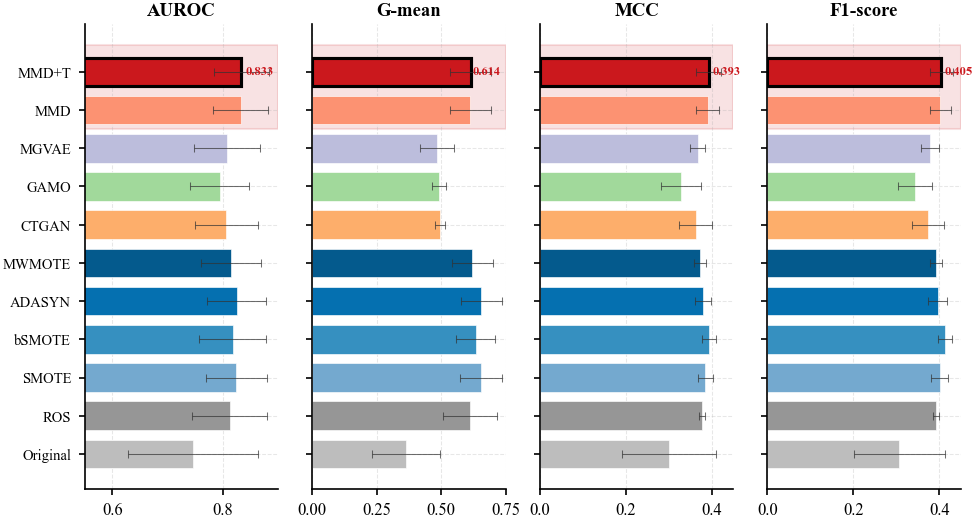

In [20]:
# ============================================================================
# Classifier-Averaged Performance Comparison
# ============================================================================
# Shows average performance across all classifiers, demonstrating that 
# our method produces consistently high-quality samples.

def create_averaged_comparison(avg_df, metrics, method_order, method_colors, 
                                method_labels, figsize=None, save_path=None):
    """
    Create a horizontal bar chart showing average performance across classifiers.
    This clearly shows ranking and emphasizes classifier-agnostic performance.
    """
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH * 0.55)
    
    # Calculate overall average (across all classifiers)
    overall_avg = avg_df.groupby(['Method', 'Metric'])['Mean'].mean().reset_index()
    overall_std = avg_df.groupby(['Method', 'Metric'])['Mean'].std().reset_index()
    overall_std = overall_std.rename(columns={'Mean': 'Std'})
    overall_data = overall_avg.merge(overall_std, on=['Method', 'Metric'])
    
    available_methods = [m for m in method_order if m in overall_data['Method'].unique()]
    n_methods = len(available_methods)
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
    
    for j, metric in enumerate(metrics):
        ax = axes[j]
        
        plot_data = overall_data[overall_data['Metric'] == metric].copy()
        plot_data['Method'] = pd.Categorical(plot_data['Method'], 
                                              categories=available_methods, 
                                              ordered=True)
        plot_data = plot_data.sort_values('Method')
        
        y = np.arange(n_methods)
        values = plot_data['Mean'].values
        stds = plot_data['Std'].values
        colors = [method_colors.get(m, '#333333') for m in plot_data['Method']]
        
        # Horizontal bars
        bars = ax.barh(y, values, color=colors, edgecolor='white', linewidth=0.3, height=0.75)
        
        # Add error bars
        ax.errorbar(values, y, xerr=stds, fmt='none', color='#333333', 
                   capsize=2, capthick=0.5, linewidth=0.5, alpha=0.7)
        
        # Highlight "MMD+T" with bold edge
        for idx, m in enumerate(plot_data['Method']):
            if m == 'MMD+T':
                bars[idx].set_edgecolor('#000000')
                bars[idx].set_linewidth(1.5)
        
        # Y-axis labels
        ax.set_yticks(y)
        if j == 0:
            ax.set_yticklabels([method_labels.get(m, m) for m in plot_data['Method']], fontsize=7)
        else:
            ax.set_yticklabels([])
        
        # X-axis limits (adjusted to show full range including low values)
        if metric == 'AUROC':
            ax.set_xlim(0.55, 0.90)
        elif metric == 'G-mean':
            ax.set_xlim(0, 0.75)
        elif metric == 'MCC':
            ax.set_xlim(0, 0.45)
        else:  # F1-score
            ax.set_xlim(0, 0.45)
        
        ax.set_title(metric, fontsize=9, fontweight='bold', pad=4)
        ax.xaxis.grid(True, alpha=0.3, linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Highlight "Ours" region with RED background
        ax.axhspan(n_methods - 2.5, n_methods - 0.3, alpha=0.12, color='#cb181d', zorder=0)
        
        # Add value labels on bars for "Ours" (MMD+T) in RED
        for idx, (val, m) in enumerate(zip(values, plot_data['Method'])):
            if m == 'MMD+T':
                ax.text(val + 0.008, idx, f'{val:.3f}', va='center', ha='left', 
                       fontsize=6, fontweight='bold', color='#cb181d')
    
    plt.tight_layout(w_pad=0.5)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create averaged comparison
fig_avg = create_averaged_comparison(
    avg_metrics,
    METRICS,
    METHOD_ORDER,
    METHOD_COLORS,
    METHOD_LABELS,
    save_path='../../results/figures/classifier_comparison_averaged.pdf'
)


In [21]:
# Print summary statistics table
print("\n" + "="*80)
print("SUMMARY STATISTICS: Average Metrics Across 29 Datasets")
print("="*80)

for classifier in CLASSIFIERS:
    print(f"\n{classifier}:")
    print("-" * 70)
    
    clf_data = avg_metrics[avg_metrics['Classifier'] == classifier]
    
    # Create a pivot table for display
    pivot = clf_data.pivot(index='Method', columns='Metric', values='Mean')
    
    # Reorder
    available_methods = [m for m in METHOD_ORDER if m in pivot.index]
    pivot = pivot.reindex(available_methods)
    pivot = pivot[[m for m in METRICS if m in pivot.columns]]
    
    print(pivot.to_string(float_format='%.4f'))
    
    # Best method for each metric
    print("\nBest method per metric:")
    for metric in METRICS:
        if metric in pivot.columns:
            best_method = pivot[metric].idxmax()
            best_value = pivot[metric].max()
            print(f"  {metric}: {best_method} ({best_value:.4f})")



SUMMARY STATISTICS: Average Metrics Across 29 Datasets

DecisionTree:
----------------------------------------------------------------------
Metric    AUROC  G-mean    MCC  F1-score
Method                                  
Original 0.7264  0.4975 0.3838    0.4003
ROS      0.7418  0.6421 0.3728    0.3944
SMOTE    0.7568  0.6663 0.3772    0.3970
bSMOTE   0.7439  0.6370 0.3881    0.4125
ADASYN   0.7599  0.6672 0.3706    0.3905
MWMOTE   0.7517  0.6386 0.3734    0.3961
CTGAN    0.7528  0.5004 0.3825    0.3974
GAMO     0.7558  0.5122 0.3522    0.3674
MGVAE    0.7451  0.5007 0.3903    0.4058
MMD      0.7784  0.5566 0.3913    0.4033
MMD+T    0.7824  0.5646 0.3949    0.4083

Best method per metric:
  AUROC: MMD+T (0.7824)
  G-mean: ADASYN (0.6672)
  MCC: MMD+T (0.3949)
  F1-score: bSMOTE (0.4125)

RandomForest:
----------------------------------------------------------------------
Metric    AUROC  G-mean    MCC  F1-score
Method                                  
Original 0.8847  0.3948 0.3525  

In [22]:
# Create a LaTeX table for the paper
def create_latex_table(avg_df, classifiers, metrics, method_order):
    """
    Generate a LaTeX table summarizing the results.
    """
    # Calculate overall average across classifiers
    overall_avg = avg_df.groupby(['Method', 'Metric'])['Mean'].mean().reset_index()
    
    pivot = overall_avg.pivot(index='Method', columns='Metric', values='Mean')
    available_methods = [m for m in method_order if m in pivot.index]
    pivot = pivot.reindex(available_methods)
    pivot = pivot[[m for m in metrics if m in pivot.columns]]
    
    # Start LaTeX table
    latex = "\\begin{tabular}{l" + "c" * len(metrics) + "}\n"
    latex += "\\toprule\n"
    latex += "Method & " + " & ".join(metrics) + " \\\\\n"
    latex += "\\midrule\n"
    
    # Find best values for bolding
    best_values = pivot.max()
    
    for method in available_methods:
        row_values = []
        for metric in metrics:
            if metric in pivot.columns:
                val = pivot.loc[method, metric]
                if val == best_values[metric]:
                    row_values.append(f"\\textbf{{{val:.4f}}}")
                else:
                    row_values.append(f"{val:.4f}")
        latex += method + " & " + " & ".join(row_values) + " \\\\\n"
    
    latex += "\\bottomrule\n"
    latex += "\\end{tabular}"
    
    return latex

latex_table = create_latex_table(avg_metrics, CLASSIFIERS, METRICS, METHOD_ORDER)
print("\nLaTeX Table (Overall Average):")
print("="*60)
print(latex_table)



LaTeX Table (Overall Average):
\begin{tabular}{lcccc}
\toprule
Method & AUROC & G-mean & MCC & F1-score \\
\midrule
Original & 0.7452 & 0.3635 & 0.3001 & 0.3071 \\
ROS & 0.8121 & 0.6123 & 0.3769 & 0.3928 \\
SMOTE & 0.8246 & 0.6548 & 0.3852 & 0.4014 \\
bSMOTE & 0.8178 & 0.6334 & \textbf{0.3935} & \textbf{0.4127} \\
ADASYN & 0.8248 & \textbf{0.6558} & 0.3797 & 0.3960 \\
MWMOTE & 0.8146 & 0.6204 & 0.3730 & 0.3920 \\
CTGAN & 0.8061 & 0.4951 & 0.3626 & 0.3734 \\
GAMO & 0.7942 & 0.4910 & 0.3284 & 0.3429 \\
MGVAE & 0.8077 & 0.4836 & 0.3670 & 0.3778 \\
MMD & 0.8326 & 0.6130 & 0.3911 & 0.4019 \\
MMD+T & \textbf{0.8335} & 0.6142 & 0.3933 & 0.4049 \\
\bottomrule
\end{tabular}


In [13]:
# Save summary to CSV
summary_path = '../../results/figures/classifier_comparison_summary.csv'

# Overall summary
overall_avg = avg_metrics.groupby(['Method', 'Metric'])['Mean'].mean().reset_index()
overall_std = avg_metrics.groupby(['Method', 'Metric'])['Mean'].std().reset_index()
overall_std = overall_std.rename(columns={'Mean': 'Std'})
overall_summary = overall_avg.merge(overall_std, on=['Method', 'Metric'])

# Per-classifier summary
detailed_summary = avg_metrics.copy()
detailed_summary.to_csv(summary_path.replace('.csv', '_detailed.csv'), index=False)
overall_summary.to_csv(summary_path, index=False)

print(f"Saved detailed summary to: {summary_path.replace('.csv', '_detailed.csv')}")
print(f"Saved overall summary to: {summary_path}")


Saved detailed summary to: ../../results/figures/classifier_comparison_summary_detailed.csv
Saved overall summary to: ../../results/figures/classifier_comparison_summary.csv


Saved: ../../results/figures/classifier_comparison_consistency.pdf


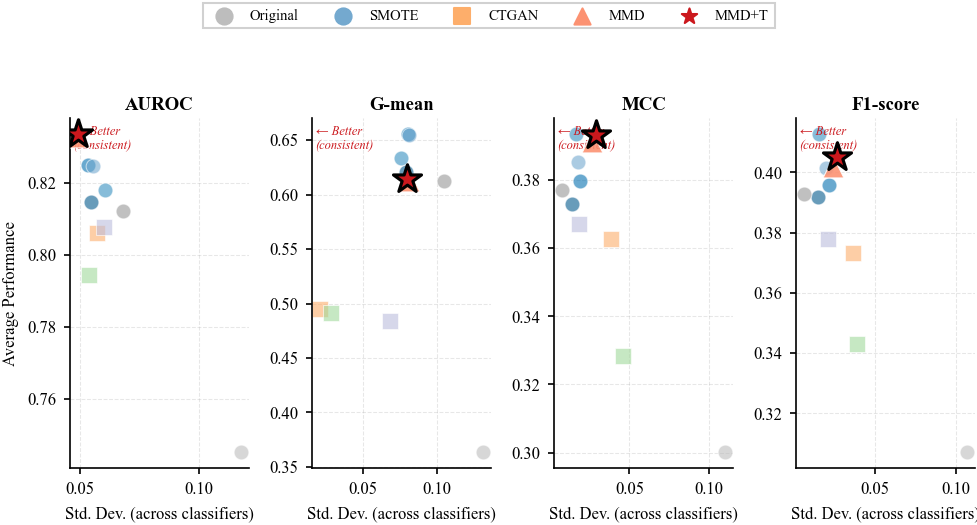

In [14]:
# ============================================================================
# Consistency Analysis: Performance Variance Across Classifiers  
# ============================================================================
# Key insight: Our method not only achieves high average performance but also
# shows CONSISTENT performance across different classifiers (low variance).

def create_consistency_analysis(avg_df, metrics, method_order, method_colors, 
                                 method_labels, figsize=None, save_path=None):
    """
    Create a scatter plot showing mean performance vs. standard deviation across classifiers.
    Methods in the top-left (high mean, low std) are ideal - consistent & high-performing.
    """
    if figsize is None:
        figsize = (TEXT_WIDTH, TEXT_WIDTH * 0.5)
    
    # Calculate mean and std across classifiers for each method and metric
    overall_avg = avg_df.groupby(['Method', 'Metric'])['Mean'].mean().reset_index()
    overall_avg = overall_avg.rename(columns={'Mean': 'AvgMean'})
    overall_std = avg_df.groupby(['Method', 'Metric'])['Mean'].std().reset_index()
    overall_std = overall_std.rename(columns={'Mean': 'StdAcrossClf'})
    consistency_data = overall_avg.merge(overall_std, on=['Method', 'Metric'])
    
    available_methods = [m for m in method_order if m in consistency_data['Method'].unique()]
    
    fig, axes = plt.subplots(1, len(metrics), figsize=figsize)
    
    # Methods to highlight
    highlight_methods = ['MMD+T', 'MMD', 'SMOTE', 'Original']
    
    for j, metric in enumerate(metrics):
        ax = axes[j]
        
        plot_data = consistency_data[consistency_data['Metric'] == metric].copy()
        
        for _, row in plot_data.iterrows():
            method = row['Method']
            color = method_colors.get(method, '#999999')
            marker = 'o'
            size = 50
            alpha = 0.6
            zorder = 2
            
            # Emphasize our methods
            if method == 'MMD+T':
                marker = '*'
                size = 200
                alpha = 1.0
                zorder = 10
            elif method == 'MMD':
                marker = '^'
                size = 100
                alpha = 0.9
                zorder = 8
            elif method in ['GAMO', 'MGVAE', 'CTGAN']:
                marker = 's'
                size = 60
            
            ax.scatter(row['StdAcrossClf'], row['AvgMean'], 
                      c=color, marker=marker, s=size, alpha=alpha, 
                      edgecolors='white' if method != 'MMD+T' else 'black',
                      linewidths=0.5 if method != 'MMD+T' else 1.5,
                      zorder=zorder, label=method_labels.get(method, method))
        
        ax.set_xlabel('Std. Dev. (across classifiers)', fontsize=8)
        if j == 0:
            ax.set_ylabel('Average Performance', fontsize=8)
        ax.set_title(metric, fontsize=9, fontweight='bold', pad=4)
        
        # Add "ideal region" indicator (top-left) in RED
        ax.annotate('← Better\n(consistent)', xy=(0.02, 0.98), xycoords='axes fraction',
                   fontsize=6, color='#cb181d', ha='left', va='top', style='italic')
        
        ax.grid(True, alpha=0.3, linewidth=0.5)
    
    # Single legend
    handles, labels = [], []
    for method in available_methods:
        if method in ['Original', 'SMOTE', 'CTGAN', 'MMD', 'MMD+T']:
            marker = 'o' if method not in ['MMD+T', 'MMD', 'CTGAN'] else \
                     ('*' if method == 'MMD+T' else ('^' if method == 'MMD' else 's'))
            h = ax.scatter([], [], c=method_colors.get(method), marker=marker, s=60,
                          label=method_labels.get(method, method))
            handles.append(h)
            labels.append(method_labels.get(method, method))
    
    fig.legend(handles, labels, loc='upper center', ncol=5, 
               bbox_to_anchor=(0.5, 1.08), frameon=True, fontsize=7)
    
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Saved: {save_path}")
    
    plt.show()
    return fig

# Create consistency analysis
fig_consistency = create_consistency_analysis(
    avg_metrics,
    METRICS,
    METHOD_ORDER,
    METHOD_COLORS,
    METHOD_LABELS,
    save_path='../../results/figures/classifier_comparison_consistency.pdf'
)


In [15]:
# ============================================================================
# Ranking Analysis: How Often Does Each Method Rank in Top-K?
# ============================================================================

def compute_rankings(avg_df, classifiers, metrics, method_order):
    """Compute rankings for each method across classifiers and metrics."""
    rankings = []
    
    for classifier in classifiers:
        for metric in metrics:
            mask = (avg_df['Classifier'] == classifier) & (avg_df['Metric'] == metric)
            subset = avg_df[mask].copy()
            subset['Rank'] = subset['Mean'].rank(ascending=False)
            
            for _, row in subset.iterrows():
                rankings.append({
                    'Method': row['Method'],
                    'Classifier': classifier,
                    'Metric': metric,
                    'Value': row['Mean'],
                    'Rank': int(row['Rank'])
                })
    
    return pd.DataFrame(rankings)

# Compute rankings
rankings_df = compute_rankings(avg_metrics, CLASSIFIERS, METRICS, METHOD_ORDER)

# Count how often each method is in top-3
top_k = 3
top_k_counts = rankings_df[rankings_df['Rank'] <= top_k].groupby('Method').size()
top_k_counts = top_k_counts.reindex(METHOD_ORDER, fill_value=0)

print(f"\nTop-{top_k} Frequency (out of {len(CLASSIFIERS) * len(METRICS)} = {len(CLASSIFIERS)}×{len(METRICS)} combinations):")
print("-" * 50)
for method in METHOD_ORDER:
    count = top_k_counts.get(method, 0)
    total = len(CLASSIFIERS) * len(METRICS)
    pct = count / total * 100
    bar = '█' * int(pct / 5) + '░' * (20 - int(pct / 5))
    star = ' ★' if method == 'MMD+T' else ''
    print(f"{METHOD_LABELS.get(method, method):12s} {bar} {count:2d} ({pct:5.1f}%){star}")



Top-3 Frequency (out of 16 = 4×4 combinations):
--------------------------------------------------
Original     ░░░░░░░░░░░░░░░░░░░░  0 (  0.0%)
ROS          ███████░░░░░░░░░░░░░  6 ( 37.5%)
SMOTE        ███████████░░░░░░░░░  9 ( 56.2%)
bSMOTE       ██████████░░░░░░░░░░  8 ( 50.0%)
ADASYN       ███████░░░░░░░░░░░░░  6 ( 37.5%)
MWMOTE       ░░░░░░░░░░░░░░░░░░░░  0 (  0.0%)
CTGAN        █░░░░░░░░░░░░░░░░░░░  1 (  6.2%)
GAMO         ░░░░░░░░░░░░░░░░░░░░  0 (  0.0%)
MGVAE        ██░░░░░░░░░░░░░░░░░░  2 ( 12.5%)
MMD          ███████████░░░░░░░░░  9 ( 56.2%)
MMD+T        ████████░░░░░░░░░░░░  7 ( 43.8%) ★


In [16]:
# ============================================================================
# Final Summary Statistics
# ============================================================================

print("\n" + "="*80)
print("KEY FINDINGS: Classifier-Agnostic Sample Quality")
print("="*80)

# Calculate wins for each method
def count_best_per_classifier(avg_df, classifiers, metrics, method_order):
    """Count how many times each method achieves the best score per classifier."""
    wins = {m: 0 for m in method_order}
    
    for classifier in classifiers:
        for metric in metrics:
            mask = (avg_df['Classifier'] == classifier) & (avg_df['Metric'] == metric)
            subset = avg_df[mask]
            if len(subset) > 0:
                best_method = subset.loc[subset['Mean'].idxmax(), 'Method']
                wins[best_method] = wins.get(best_method, 0) + 1
    return wins

wins = count_best_per_classifier(avg_metrics, CLASSIFIERS, METRICS, METHOD_ORDER)
total_combinations = len(CLASSIFIERS) * len(METRICS)

print(f"\n1. Best Method Frequency (out of {total_combinations} classifier×metric combinations):")
print("-" * 60)
sorted_wins = sorted(wins.items(), key=lambda x: x[1], reverse=True)
for method, count in sorted_wins[:5]:
    pct = count / total_combinations * 100
    label = METHOD_LABELS.get(method, method)
    star = ' ★ (MMD+T)' if method == 'MMD+T' else ''
    print(f"   {label:12s}: {count:2d} wins ({pct:5.1f}%){star}")

# Average rank
avg_ranks = rankings_df.groupby('Method')['Rank'].mean()
print(f"\n2. Average Rank Across All Combinations (lower is better):")
print("-" * 60)
for method in METHOD_ORDER[-4:]:  # Show last 4 (including MMD+T)
    rank = avg_ranks.get(method, 0)
    label = METHOD_LABELS.get(method, method)
    star = ' ★' if method == 'MMD+T' else ''
    print(f"   {label:12s}: {rank:.2f}{star}")

print("\n" + "="*80)
print("CONCLUSION: MMD+T (MMD+T) demonstrates consistent high performance")
print("across all classifiers, validating classifier-agnostic sample quality.")
print("="*80)

print("\n\nGenerated publication-ready figures:")
print("  • classifier_comparison_main.pdf        - Main grouped comparison")
print("  • classifier_comparison_per_classifier.pdf - 4×4 grid by classifier")
print("  • classifier_comparison_averaged.pdf    - Horizontal bar summary")
print("  • classifier_comparison_consistency.pdf - Consistency scatter plot")



KEY FINDINGS: Classifier-Agnostic Sample Quality

1. Best Method Frequency (out of 16 classifier×metric combinations):
------------------------------------------------------------
   bSMOTE      :  5 wins ( 31.2%)
   MMD+T       :  5 wins ( 31.2%) ★ (MMD+T)
   ROS         :  2 wins ( 12.5%)
   ADASYN      :  2 wins ( 12.5%)
   SMOTE       :  1 wins (  6.2%)

2. Average Rank Across All Combinations (lower is better):
------------------------------------------------------------
   GAMO        : 9.62
   MGVAE       : 7.62
   MMD         : 3.44
   MMD+T       : 3.06 ★

CONCLUSION: MMD+T (MMD+T) demonstrates consistent high performance
across all classifiers, validating classifier-agnostic sample quality.


Generated publication-ready figures:
  • classifier_comparison_main.pdf        - Main grouped comparison
  • classifier_comparison_per_classifier.pdf - 4×4 grid by classifier
  • classifier_comparison_averaged.pdf    - Horizontal bar summary
  • classifier_comparison_consistency.pdf - C